# Introduction
[TensorFlow Serving]((https://www.tensorflow.org/tfx/guide/serving)) is a flexible and high-performance library that serves machine learning models. It simplifies the deployment of new algorithms and experiments while maintaining consistent server architecture and APIs. This tutorial provides a step-by-step guide on training a model, saving it, and serving it using TensorFlow Serving.

The tutorial uses a straightforward model to ensure clarity, emphasizing the serving process.

Model Details:

Dataset: The Fashion MNIST dataset, which contains grayscale images of 10 different clothing types. Each image is 28x28 pixels.

Architecture:
Input: Flatten layer to transform the 2D 28x28 pixel image into a 1D array.

Hidden: Dense layer with 128 neurons and ReLU activation.

Output: Dense layer with 10 neurons representing the clothing categories.

# Importing necessary libraries
Start by importing the necessary libraries and loading the dataset.

In [ ]:
import os
import subprocess
import json
import requests
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Loading and Preprocessing data

[Fashion MNIST](https://www.tensorflow.org/datasets/catalog/fashion_mnist) a dataset introduced as an alternative to the traditional MNIST dataset. While the classic MNIST contains handwritten digits, Fashion MNIST showcases images of Zalando's articles, aiming to provide a more challenging benchmark for machine learning algorithms.

For the purpose of this demonstration, the pixel values of these images are normalized between 0 and 1 to aid in the training process of the neural network.

Now, let's load the dataset and visualize some of its content.

In [ ]:
def load_and_preprocess_data():
    # Load the Fashion MNIST dataset
    (train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

    # Normalize the pixel values
    train_images = train_images / 255.0
    test_images = test_images / 255.0

    return train_images, train_labels, test_images, test_labels

In [ ]:
def display_sample_images(train_images, train_labels, class_names):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[train_labels[i]])
    plt.show()

4422102/4422102 [==============================] - 0s 0us/step


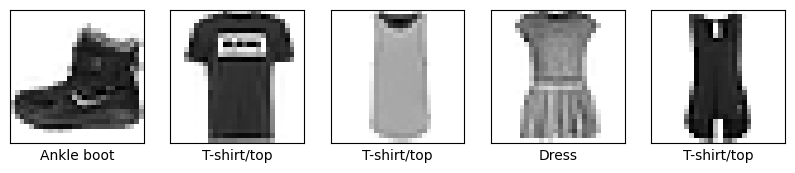

In [ ]:
train_images, train_labels, test_images, test_labels = load_and_preprocess_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

display_sample_images(train_images, train_labels, class_names)


# Model creation and Training

Define a neural network model, complile it, and train it.

In [ ]:
def create_and_train_model(train_images, train_labels):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10)
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    model.fit(train_images, train_labels, epochs=5)
    return model

In [ ]:
model = create_and_train_model(train_images, train_labels)
model.summary()


Epoch 1/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4981 - accuracy: 0.8254
Epoch 2/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3762 - accuracy: 0.8648
Epoch 3/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.3364 - accuracy: 0.8779
Epoch 4/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3116 - accuracy: 0.8848
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2937 - accuracy: 0.8912
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
       

# Saving the Model for TensorFlow Serving

Save the trained model in TensorFlow's SavedModel format, which is optimized for serving.

In [ ]:
def save_model_for_serving(model, MODEL_DIR, version=1):
    export_path = os.path.join(MODEL_DIR, str(version))
    tf.keras.models.save_model(
        model,
        export_path,
        overwrite=True,
        include_optimizer=True
    )
    return export_path

In [ ]:
MODEL_DIR = os.path.abspath("saved_model")

export_path = save_model_for_serving(model, MODEL_DIR)
print(f'Files of model saved in {export_path}:\n')
print(os.listdir(export_path))


Files of model saved in /content/saved_model/1:

['variables', 'saved_model.pb', 'keras_metadata.pb', 'assets', 'fingerprint.pb']


# Examining the Saved Model

In [ ]:
!saved_model_cli show --dir {export_path} --tag_set serve --signature_def serving_default

2023-09-28 14:57:42.326913: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The given SavedModel SignatureDef contains the following input(s):
  inputs['flatten_2_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 28, 28)
      name: serving_default_flatten_2_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_5'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


## Install TensorFlow Serving

Install TensorFlow Seving on the Colab instance

In [ ]:
!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb'
!dpkg -i tensorflow-model-server-universal_2.8.0_all.deb


--2023-09-28 14:57:45--  http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.207, 172.253.63.207, 142.250.31.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335421916 (320M) [application/x-debian-package]
Saving to: ‘tensorflow-model-server-universal_2.8.0_all.deb.2’

tensorflow-model-se 100%[===================>] 319.88M  49.0MB/s    in 6.0s    

2023-09-28 14:57:51 (53.4 MB/s) - ‘tensorflow-model-server-universal_2.8.0_all.deb.2’ saved [335421916/335421916]

(Reading database ... 120896 files and directories currently installed.)
Preparing to unpack tensorflow-model-server-universal_2.8.0_all.deb ...
Unpacking tensorflow-model-server-universal (2.8.0) over (2.8.0) ...
Settin

## Start Running TensorFlow Serving

In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
def serve_model(MODEL_DIR, log_file_path="server.log"):
    command = ("tensorflow_model_server --rest_api_port=8501 "
               "--model_name=fashion_model "
               f"--model_base_path={MODEL_DIR}")
    with open(log_file_path, "a") as log_file:
        proc = subprocess.Popen(command.split(), stdout=log_file, stderr=subprocess.STDOUT)
    return proc

In [ ]:
server_process = serve_model(MODEL_DIR)


# Making Predictions with the Served Model

In [ ]:
def make_inference_request(img):
    data = json.dumps({"instances": img.tolist()})
    headers = {"content-type": "application/json"}
    url = 'http://localhost:8501/v1/models/fashion_model:predict'
    response = requests.post(url, data=data, headers=headers)
    predictions = json.loads(response.text)['predictions']
    return predictions

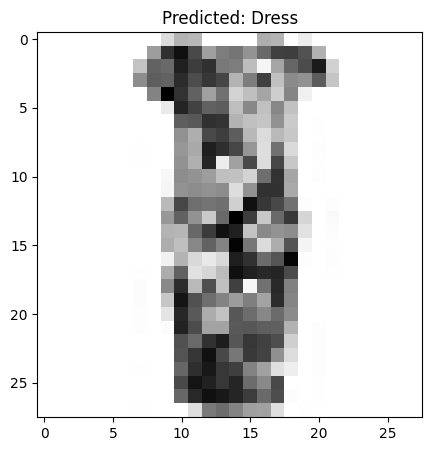

In [ ]:
predictions = make_inference_request(test_images[100])
predicted_label = np.argmax(predictions[0])

plt.figure(figsize=(5, 5))
plt.imshow(test_images[100], cmap=plt.cm.binary)
plt.title(f"Predicted: {class_names[predicted_label]}")
plt.show()


# Shutting Down the TensorFlow ModelServer

After serving your model and making predictions, it's a good practice to shut down the TensorFlow ModelServer, especially if you're running on limited resources or in an environment like Google Colab.

To gracefully shut down the server:

In [ ]:
# Gracefully terminate the process
server_process.terminate()

# Wait for a moment to ensure it's terminated
server_process.wait()


-15

# Conclusion

TensorFlow Serving offers a consistent and efficient way to deploy machine learning models. The server can manage multiple models, handle different versions of the same model, and even enable A/B testing of live models.

# References

TensorFlow Serving: https://www.tensorflow.org/tfx/guide/serving